In [ ]:
import math
import pandas_datareader as web
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

plt.style.use('fivethirtyeight')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
tesla = pd.read_csv('/content/drive/MyDrive/TSLA.csv')

In [ ]:
print(tesla.head())
print("checking if any null values are present\n", tesla.isna().sum())

         Date       Open       High        Low      Close  Adj Close    Volume
0  2016-08-16  45.098000  45.438000  44.681999  44.722000  44.722000  11335500
1  2016-08-17  44.866001  44.966000  44.560001  44.647999  44.647999   8935500
2  2016-08-18  44.764000  45.132000  44.458000  44.702000  44.702000   8572500
3  2016-08-19  44.708000  45.034000  44.506001  45.000000  45.000000   8297500
4  2016-08-22  44.834000  45.021999  44.535999  44.585999  44.585999  10327500
checking if any null values are present
 Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


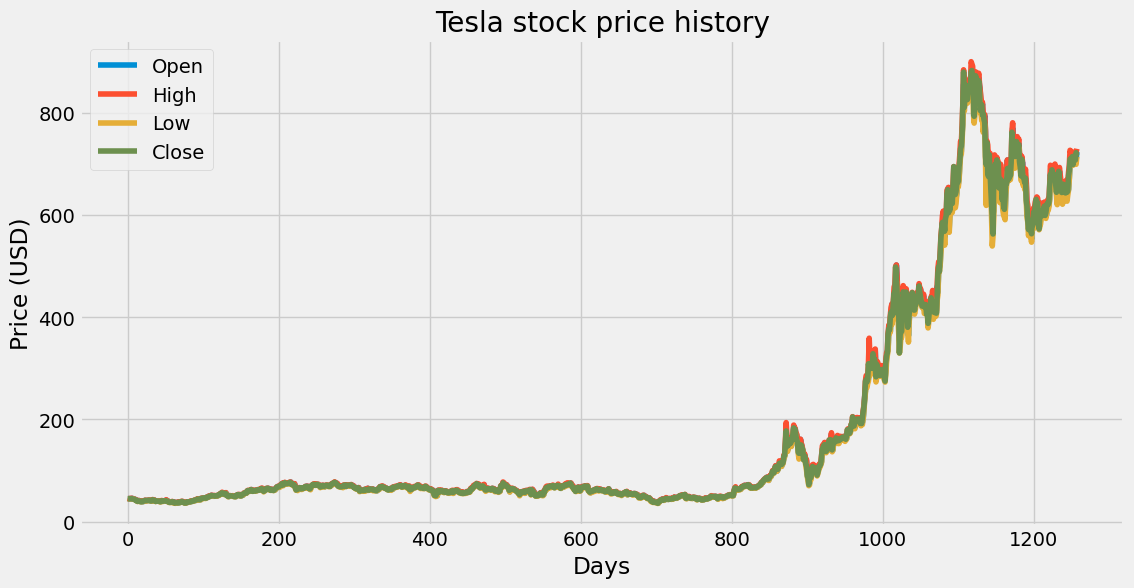

In [ ]:
plt.figure(figsize = (12,6))
plt.plot(tesla["Open"])
plt.plot(tesla["High"])
plt.plot(tesla["Low"])
plt.plot(tesla["Close"])
plt.title('Tesla stock price history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()

Implement univariate model

Create a dataframe with only the Close Stock Price Column


In [ ]:
data_target = tesla.filter(['Close'])

target = data_target.values

training_data_len = math.ceil(len(target)* 0.75) # training set has 75% of the data
training_data_len

# Normalizing data bef
sc = MinMaxScaler(feature_range=(0,1))
training_scaled_data = sc.fit_transform(target)
training_scaled_data

array([[0.01053705],
       [0.01044971],
       [0.01051345],
       ...,
       [0.79314193],
       [0.81017257],
       [0.80417701]])

 Create a training dataset containing the last 180-day closing price values we want to use to estimate the 181st closing price value.

In [ ]:
train_data = training_scaled_data[0:training_data_len  , : ]

X_train = []
y_train = []
for i in range(180, len(train_data)):
    X_train.append(train_data[i-180:i, 0])
    y_train.append(train_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train) # converting into numpy sequences to train the LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print('Number of rows and columns: ', X_train.shape)  #(854 values, 180 time-steps, 1 o

Number of rows and columns:  (764, 180, 1)


Train the model

In [ ]:
from keras.layers import SimpleRNN

model = Sequential()

# Adding RNN layers and some Dropout regularisation
model.add(SimpleRNN(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(SimpleRNN(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(SimpleRNN(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(SimpleRNN(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(X_train, y_train, epochs = 10, batch_size = 32)

Epoch 1/10
24/24 [==============================] - 10s 262ms/step - loss: 0.4070
Epoch 2/10
24/24 [==============================] - 5s 189ms/step - loss: 0.2289
Epoch 3/10
24/24 [==============================] - 4s 184ms/step - loss: 0.1779
Epoch 4/10
24/24 [==============================] - 6s 274ms/step - loss: 0.1473
Epoch 5/10
24/24 [==============================] - 4s 186ms/step - loss: 0.1086
Epoch 6/10
24/24 [==============================] - 5s 220ms/step - loss: 0.0705
Epoch 7/10
24/24 [==============================] - 6s 265ms/step - loss: 0.0388
Epoch 8/10
24/24 [==============================] - 4s 186ms/step - loss: 0.0271
Epoch 9/10
24/24 [==============================] - 6s 233ms/step - loss: 0.0172
Epoch 10/10
24/24 [==============================] - 5s 221ms/step - loss: 0.0129


In [ ]:
test_data = training_scaled_data[training_data_len - 180: , : ]

X_test = []
y_test =  target[training_data_len : , : ]
for i in range(180,len(test_data)):
    X_test.append(test_data[i-180:i,0])

X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
print('Number of rows and columns: ', X_test.shape)


Number of rows and columns:  (314, 180, 1)


Calculate the evaluation metrics


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

actual_stock_price = sc.inverse_transform(y_test)

mae = mean_absolute_error(actual_stock_price, predicted_stock_price)
mse = mean_squared_error(actual_stock_price, predicted_stock_price)
r2 = r2_score(actual_stock_price, predicted_stock_price)

# Print the evaluation metrics
print('MAE:', mae)
print('MSE:', mse)
print('R2 score:', r2)


10/10 [==============================] - 1s 45ms/step
MAE: 455994.3426896887
MSE: 235248823293.37515
R2 score: -7.605265867758645


Visualising the results


<ipython-input-58-feaf67f71f79>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Test['Predictions'] = predicted_stock_price


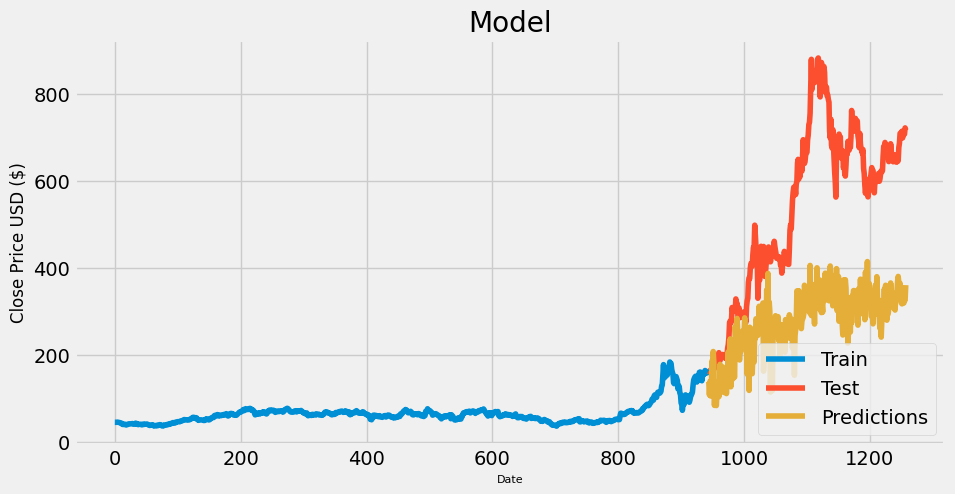

In [ ]:
train = data_target[:training_data_len]
Test = data_target[training_data_len:]
Test['Predictions'] = predicted_stock_price
plt.figure(figsize=(10,5))
plt.title('Model')
plt.xlabel('Date', fontsize=8)
plt.ylabel('Close Price USD ($)', fontsize=12)
plt.plot(train['Close'])
plt.plot(Test[['Close', 'Predictions']])
plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
Test

,Close,Predictions
944,162.725998,137.650375
945,161.602005,107.685432
946,163.112000,138.957230
947,165.520004,105.229225
948,163.376007,118.805565
...,...,...
1253,713.760010,332.463165
1254,709.989990,319.257233
1255,707.820007,327.323364
1256,722.250000,326.046112


Use LSTM

In [ ]:

model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(X_train, y_train, epochs = 10, batch_size = 32)

Epoch 1/10
24/24 [==============================] - 20s 466ms/step - loss: 8.5008e-04
Epoch 2/10
24/24 [==============================] - 11s 469ms/step - loss: 3.3626e-04
Epoch 3/10
24/24 [==============================] - 9s 393ms/step - loss: 2.7991e-04
Epoch 4/10
24/24 [==============================] - 12s 510ms/step - loss: 2.3179e-04
Epoch 5/10
24/24 [==============================] - 11s 464ms/step - loss: 2.3579e-04
Epoch 6/10
24/24 [==============================] - 11s 459ms/step - loss: 1.7987e-04
Epoch 7/10
24/24 [==============================] - 9s 381ms/step - loss: 1.6193e-04
Epoch 8/10
24/24 [==============================] - 11s 439ms/step - loss: 2.0584e-04
Epoch 9/10
24/24 [==============================] - 11s 456ms/step - loss: 1.3701e-04
Epoch 10/10
24/24 [==============================] - 11s 456ms/step - loss: 1.2827e-04


In [ ]:
test_data = training_scaled_data[training_data_len - 180: , : ]

X_test = []
y_test =  target[training_data_len : , : ]
for i in range(180,len(test_data)):
    X_test.append(test_data[i-180:i,0])

X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
print('Number of rows and columns: ', X_test.shape)

Number of rows and columns:  (314, 180, 1)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

actual_stock_price = sc.inverse_transform(y_test)

mae = mean_absolute_error(actual_stock_price, predicted_stock_price)
mse = mean_squared_error(actual_stock_price, predicted_stock_price)
r2 = r2_score(actual_stock_price, predicted_stock_price)

print('MAE:', mae)
print('MSE:', mse)
print('R2 score:', r2)

10/10 [==============================] - 3s 153ms/step
MAE: 455874.7533016857
MSE: 235122989532.40088
R2 score: -7.6006629415753615


Visualising the results


<ipython-input-63-feaf67f71f79>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Test['Predictions'] = predicted_stock_price


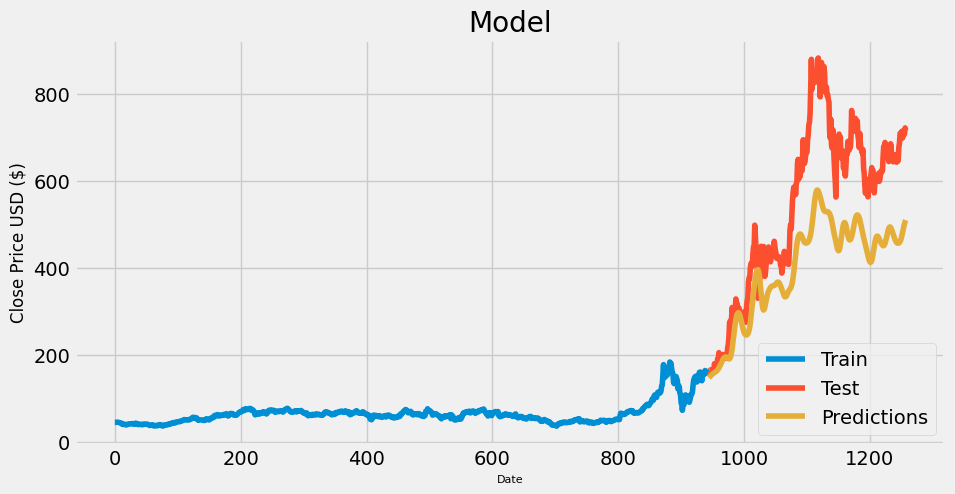

In [ ]:
train = data_target[:training_data_len]
Test = data_target[training_data_len:]
Test['Predictions'] = predicted_stock_price
plt.figure(figsize=(10,5))
plt.title('Model')
plt.xlabel('Date', fontsize=8)
plt.ylabel('Close Price USD ($)', fontsize=12)
plt.plot(train['Close'])
plt.plot(Test[['Close', 'Predictions']])
plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
Test

,Close,Predictions
944,162.725998,147.344894
945,161.602005,148.700974
946,163.112000,150.181656
947,165.520004,151.700256
948,163.376007,153.214890
...,...,...
1253,713.760010,488.877899
1254,709.989990,495.697449
1255,707.820007,501.692139
1256,722.250000,506.462677


Use GRU

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense

model = Sequential()

model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(GRU(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
24/24 [==============================] - 20s 458ms/step - loss: 5.3756e-04
Epoch 2/10
24/24 [==============================] - 11s 454ms/step - loss: 1.6612e-04
Epoch 3/10
24/24 [==============================] - 10s 437ms/step - loss: 1.2067e-04
Epoch 4/10
24/24 [==============================] - 9s 378ms/step - loss: 1.1195e-04
Epoch 5/10
24/24 [==============================] - 11s 456ms/step - loss: 1.1633e-04
Epoch 6/10
24/24 [==============================] - 11s 452ms/step - loss: 9.8128e-05
Epoch 7/10
24/24 [==============================] - 10s 398ms/step - loss: 1.5157e-04
Epoch 8/10
24/24 [==============================] - 10s 415ms/step - loss: 1.1231e-04
Epoch 9/10
24/24 [==============================] - 11s 456ms/step - loss: 9.0969e-05
Epoch 10/10
24/24 [==============================] - 11s 456ms/step - loss: 9.9488e-05


In [ ]:
test_data = training_scaled_data[training_data_len - 180: , : ]

X_test = []
y_test =  target[training_data_len : , : ]
for i in range(180,len(test_data)):
    X_test.append(test_data[i-180:i,0])

X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
print('Number of rows and columns: ', X_test.shape)

Number of rows and columns:  (314, 180, 1)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

actual_stock_price = sc.inverse_transform(y_test)

mae = mean_absolute_error(actual_stock_price, predicted_stock_price)
mse = mean_squared_error(actual_stock_price, predicted_stock_price)
r2 = r2_score(actual_stock_price, predicted_stock_price)

print('MAE:', mae)
print('MSE:', mse)
print('R2 score:', r2)

10/10 [==============================] - 4s 84ms/step
MAE: 455760.0000582211
MSE: 234994750255.59665
R2 score: -7.595972023014577


Visualising the results


<ipython-input-68-feaf67f71f79>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Test['Predictions'] = predicted_stock_price


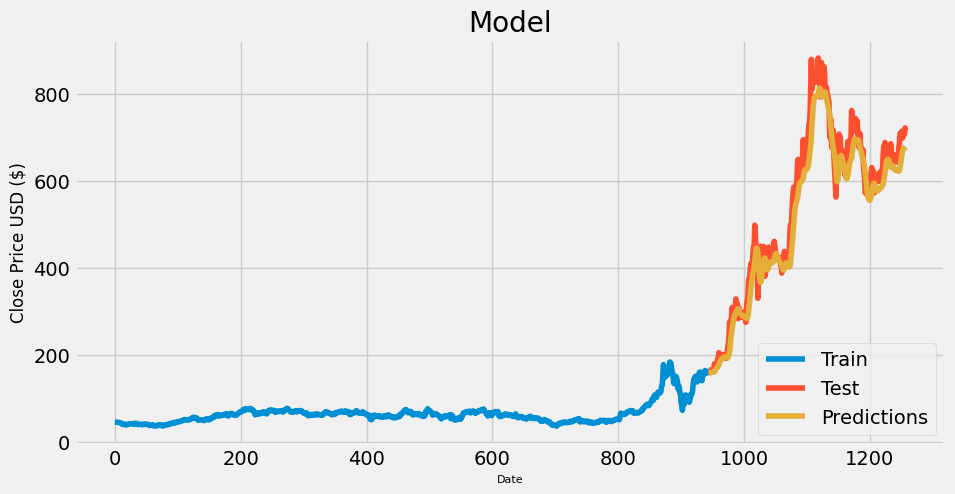

In [ ]:
train = data_target[:training_data_len]
Test = data_target[training_data_len:]
Test['Predictions'] = predicted_stock_price
plt.figure(figsize=(10,5))
plt.title('Model')
plt.xlabel('Date', fontsize=8)
plt.ylabel('Close Price USD ($)', fontsize=12)
plt.plot(train['Close'])
plt.plot(Test[['Close', 'Predictions']])
plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
plt.show()

Implement multivariate model

In [ ]:
# Create a dataframe with only the Close Stock Price Column
data_target = tesla.filter(['Open', 'Close'])

# Convert the dataframe to a numpy array to train the LSTM model
target = data_target.values

# Splitting the dataset into training and test
# Target Variable: Close stock price value

training_data_len = math.ceil(len(target)* 0.75) # training set has 75% of the data
training_data_len

# Normalizing data before model fitting using MinMaxScaler
# Feature Scaling

sc = MinMaxScaler(feature_range=(0,1))
training_scaled_data = sc.fit_transform(target)
training_scaled_data

array([[0.01038168, 0.01053705],
       [0.01011039, 0.01044971],
       [0.00999111, 0.01051345],
       ...,
       [0.79106836, 0.79314193],
       [0.78361947, 0.81017257],
       [0.80393145, 0.80417701]])

In [ ]:
train_data = training_scaled_data[0:training_data_len  , : ]

X_train = []
y_train = []
for i in range(180, len(train_data)):
    X_train.append(train_data[i-180:i, 0:2])
    y_train.append(train_data[i, 0:2])

X_train, y_train = np.array(X_train), np.array(y_train) # converting into numpy sequences to train the LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 2))
print('Number of rows and columns: ', X_train.shape)  #(854 values, 180 time-steps, 1 o

Number of rows and columns:  (764, 180, 2)


In [ ]:
model = Sequential()

model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 2)))
model.add(Dropout(0.2))

model.add(GRU(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=2))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
24/24 [==============================] - 19s 366ms/step - loss: 5.6092e-04
Epoch 2/10
24/24 [==============================] - 11s 450ms/step - loss: 1.9221e-04
Epoch 3/10
24/24 [==============================] - 11s 450ms/step - loss: 1.2558e-04
Epoch 4/10
24/24 [==============================] - 9s 392ms/step - loss: 1.2369e-04
Epoch 5/10
24/24 [==============================] - 10s 419ms/step - loss: 1.1987e-04
Epoch 6/10
24/24 [==============================] - 11s 453ms/step - loss: 1.2180e-04
Epoch 7/10
24/24 [==============================] - 11s 465ms/step - loss: 9.6209e-05
Epoch 8/10
24/24 [==============================] - 9s 381ms/step - loss: 1.0293e-04
Epoch 9/10
24/24 [==============================] - 11s 459ms/step - loss: 9.9332e-05
Epoch 10/10
24/24 [==============================] - 11s 462ms/step - loss: 1.1221e-04


In [ ]:
test_data = training_scaled_data[training_data_len - 180: , : ]

X_test = []
y_test =  target[training_data_len : , : ]
for i in range(180,len(test_data)):
    X_test.append(test_data[i-180:i,0:2])

X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],2))
print('Number of rows and columns: ', X_test.shape)

Number of rows and columns:  (314, 180, 2)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

actual_stock_price = sc.inverse_transform(y_test)

mae = mean_absolute_error(actual_stock_price, predicted_stock_price)
mse = mean_squared_error(actual_stock_price, predicted_stock_price)
r2 = r2_score(actual_stock_price, predicted_stock_price)

print('MAE:', mae)
print('MSE:', mse)
print('R2 score:', r2)

10/10 [==============================] - 2s 85ms/step
MAE: 457763.13875224895
MSE: 237118930724.38107
R2 score: -7.581633340226512


Visualising the results


<ipython-input-74-d31c8523b85e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Test['Predictions'] = predicted_stock_price[:,0]


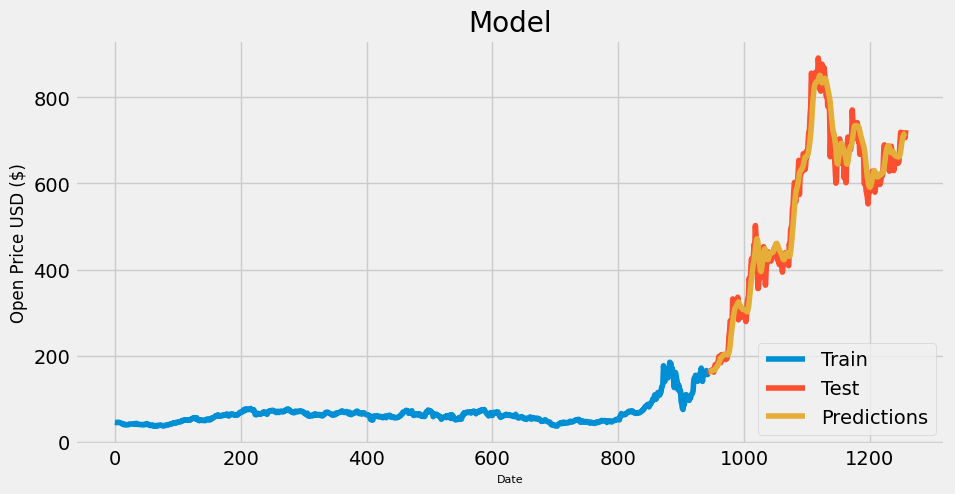

In [ ]:
train = data_target[:training_data_len]
Test = data_target[training_data_len:]
Test['Predictions'] = predicted_stock_price[:,0]
plt.figure(figsize=(10,5))
plt.title('Model')
plt.xlabel('Date', fontsize=8)
plt.ylabel('Open Price USD ($)', fontsize=12)
plt.plot(train['Open'])
plt.plot(Test[['Open', 'Predictions']])
plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
plt.show()

<ipython-input-75-2f3fad700172>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Test['Predictions'] = predicted_stock_price[:,1]


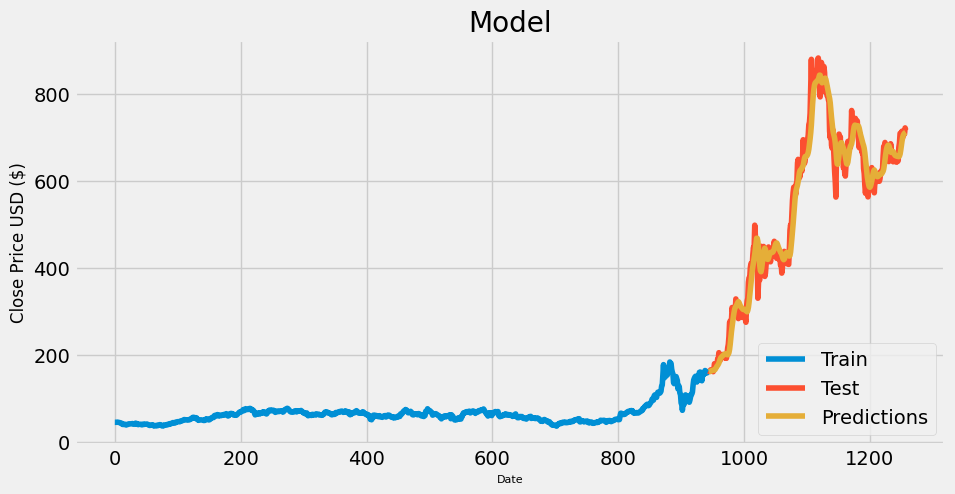

In [ ]:
train = data_target[:training_data_len]
Test = data_target[training_data_len:]
Test['Predictions'] = predicted_stock_price[:,1]
plt.figure(figsize=(10,5))
plt.title('Model')
plt.xlabel('Date', fontsize=8)
plt.ylabel('Close Price USD ($)', fontsize=12)
plt.plot(train['Close'])
plt.plot(Test[['Close', 'Predictions']])
plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
plt.show()